# Preprocess Image Data from Raw Data

In [2]:
import pandas as pd
import time
from math import sqrt, pow, floor
from Scripts.KernelReg.KernelRegression import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Read the data

In [5]:
fd = pd.read_pickle("../Raw/fd.pkl")

In [6]:
features = ['Mach', 'Turb_Var_Chi', 'Turb_Var_Omega',
       'Turb_Var_S', 'Den_Grad_X', 'Den_Grad_Y',
       'Vel_Grad_XX', 'Vel_Grad_XY', 'Vel_Grad_YX', 'Vel_Grad_YY',
       'Pres_Grad_X', 'Pres_Grad_Y',
       'Heat_Flux', 'Eddy_Viscosity']
means = []
for f in features:
    print(f, 'min: ', min(fd[f]),'max: ', max(fd[f]))

Mach min:  0.0 max:  0.6055165138445859
Turb_Var_Chi min:  0.001868454135732041 max:  13207.48470087414
Turb_Var_Omega min:  2.753034850436209e-09 max:  42714.921478879245
Turb_Var_S min:  2.753034850436209e-09 max:  37897.135874986765
Den_Grad_X min:  -12758.01543289031 max:  9518.125427962812
Den_Grad_Y min:  -16815.03497503484 max:  13932.639725076951
Vel_Grad_XX min:  -42714.921478879245 max:  1006.599410577314
Vel_Grad_XY min:  -9520.534595526595 max:  12742.92357026478
Vel_Grad_YX min:  -3814.9494511811267 max:  657.7961930513623
Vel_Grad_YY min:  -4805.409451433434 max:  1050.8959221561079
Pres_Grad_X min:  -4565.9310762351615 max:  238.6522048116658
Pres_Grad_Y min:  -983.8827420516634 max:  1903.761364052603
Heat_Flux min:  -2253.838004301427 max:  9603.70130055727
Eddy_Viscosity min:  0.0 max:  0.0012092927100644


In [7]:
scaler = MinMaxScaler()
fd[features] = scaler.fit_transform(fd[features])

### Make the Data Domain, D
Domain Points: $ d \times d$ <br>
d = 0.02
##### Identify coordinates to make pictures

In [8]:
d = 0.01
# NACA0012 case
x = np.arange(-0.25, 2, d)
y = np.arange(-0.25, 0.25, d)
xx, yy = np.meshgrid(x,y)
coords = [(a1, b1,) for a, b in zip(xx, yy) for a1, b1, in zip(a, b) ]
# NACA0021 case
x2 = np.arange(-0.25, 3, d)
y2 = np.arange(-0.25, 0.25, d)
xx2, yy2 = np.meshgrid(x2,y2)
coords2 = [(a1, b1,) for a, b in zip(xx2, yy2) for a1, b1, in zip(a, b) ]

### Remove the airfoil

In [9]:
def n12(xc):
    t1 = 0.298222773*sqrt(xc) - 0.127125232*xc - 0.357907906*pow(xc, 2) +\
         0.291984971*pow(xc, 3) - 0.105174606*pow(xc, 4)
    return 0.594689181*t1

def n21(xc):
    return 1.05*(0.2969*sqrt(xc) - 0.1260*xc - 0.3516*pow(xc,2) + 0.2843*pow(xc,3) - 0.1015*pow(xc,4))


coords_12 = [x for x in coords if (0.0 <= x[0] <= 1.0) and (abs(x[1] >= n12(x[0])))]
coords_21 = [x for x in coords2 if (0.0 <= x[0] <= 1.0) and (abs(x[1] >= n21(x[0])))]

### Make Pictures
Parameters: <br>
Size of resulting image: $ n \times n $ <br>
Data bounds for Kernel : $ r $   <br>
picture width : $ w $ <br>
n = 20 <br>
r = 0.1 <br>
w = 0.05 <br>
<br>
### Modus Operandii:
Picture coordinates have the same relative locations with respect to the center. <br>

In [10]:
r = 0.02
w = 0.015
n = 20
ker_dist = 1e-3

aoa = [2, 4, 6, 10, 11, 12, 13, 16, 17, 18]
aoa2 = [210, 216, 2116, 2120]

In [11]:
full_arr = []
full_beta = []
for i in (aoa + aoa2):
    df_temp = fd.query('ilevel_1 == "'+str(i)+'"')
    if i in aoa:
        coo = coords_12
        foil = n12
    else:
        coo = coords_21
        foil = n21
    for center in coo:
        point_array = []
        feature_array = []
        ax = np.linspace(center[0] -w/2,center[0] + w/2, n)
        ay = np.linspace(center[1] -w/2,center[1] + w/2, n)
        axx, ayy = np.meshgrid(ax, ay)
        abs_coords = [(a1, b1,) for a, b in zip(axx, ayy) for a1, b1, in zip(a, b)]
        # Extract neighbors
        nbs = pick_neighbors(df_temp, center[0], center[1], r)
        dists = []
        in_foil = []
        for point in abs_coords:
            dists.append(np.sqrt(np.square(nbs['x'].to_numpy() - point[0])
                                     + np.square(nbs['y'].to_numpy() - point[1])))
            # Check if the point is inside the airfoil
            if (0. <= point[0] <= 1.) and (abs(point[1]) <= foil(point[0])):
                in_foil.append(True)
            else:
                in_foil.append(False)
        p = np.vstack(dists)
        kernels = (1 / np.sqrt(2 * np.pi)) * np.exp(-p / ker_dist)
        ker_sum = np.dot(kernels, np.ones(kernels.shape[1])) + 1e-8
        for f in features:
            try:
                pred_arr = np.divide(np.dot(kernels, nbs[f].to_numpy()), ker_sum)
            except ZeroDivisionError:
                pred_arr = np.zeros(kernels.shape[0])
            # Set airfoil points to zero
            pred_arr = [x if not y else 0. for (x, y) in zip(pred_arr, in_foil)]
            feature_array.append(pred_arr)
        # Stack features
        point_array = np.vstack(feature_array)
        # Calculate the field parameter
        nbs_x = nbs['x'].to_numpy()
        nbs_y = nbs['y'].to_numpy()
        dists_c = np.sqrt(np.square(nbs_x - center[0]) + np.square(nbs_y - center[1]))
        kernels_c = (1 / np.sqrt(2 * np.pi)) * np.exp(-dists_c / ker_dist)
        ker_sum_c = np.dot(kernels_c, np.ones(kernels_c.shape[0])) + 1e-8
        try:
            beta = np.divide(np.dot(kernels_c, nbs['Field_Parameter'].to_numpy()), ker_sum_c)
        except ZeroDivisionError:
            beta = 0.0
        full_beta.append(beta)
        full_arr.append(point_array)

np.save('../Data/pics.npy', np.asarray(full_arr))
np.save('../Data/pics_beta.npy', np.asarray(full_beta))

### Eye Norm

In [175]:

df = np.load('../Data/pics_11.npy', allow_pickle=True)

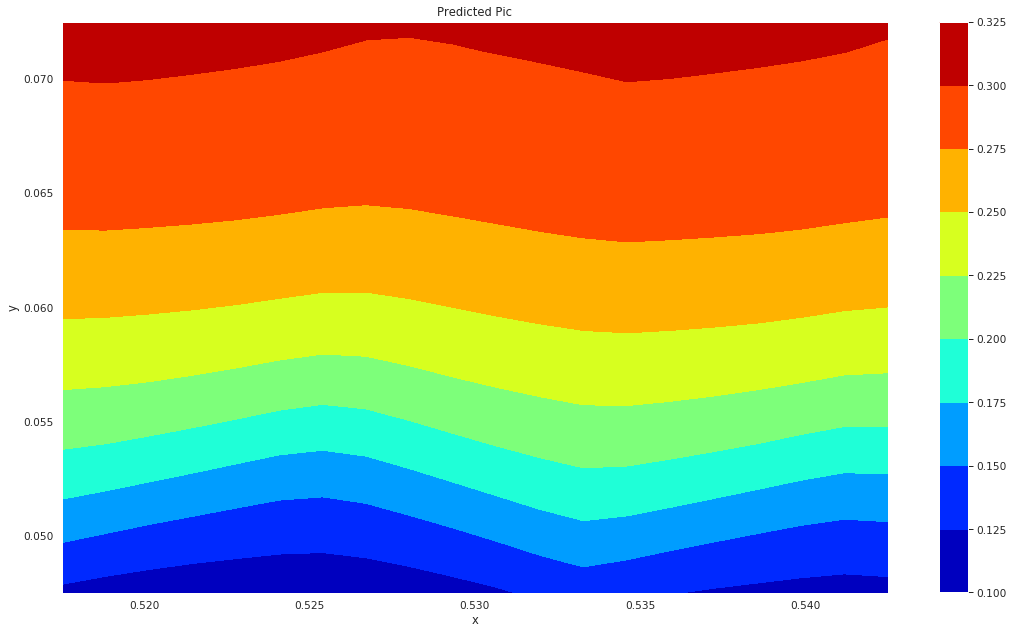

In [176]:
f = 2884
j = floor(f/14)
p = np.reshape(df[f],(20,20), order='F')
xc = coords_12[j][0]
yc = coords_12[j][1]
gx = np.linspace(xc-0.025/2, xc + 0.025/2, num=20)
gy = np.linspace( yc-0.025/2, yc +  0.025/2, num=20)
xp, yp = np.meshgrid(gx, gy, sparse=False, indexing='ij')
sp = gx[1] - gx[0]

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(xp, yp, p.reshape(xp.shape), cmap=cm.jet)
ax.set_rasterization_zorder(-10)
fig.colorbar(cp)
ax.set_title('Predicted Pic')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.set_size_inches(18.5, 10.5)
plt.show()


image = sitk.GetImageFromArray(p.reshape(xp.shape), isVector=False)

image.SetOrigin((coords_12[j][0],coords_12[j][1] , 0))
image.SetSpacing((sp, sp, 1))
#sitk.WriteImage(image, 'test.vtk')

In [13]:
dfb2 = np.load('../Data/pics_beta.npy', allow_pickle=True)
print(max(dfb2), np.argmax(dfb2))

1.050891804277209 20645
